## Wasserstein GAN with Gradient Penalty

WGAN이 사용하는 weight clipping은 과대 적합, 과소 적합을 야기할 위험이 있음. 명백한 가중치의 interval을 제공하는 것이 부정확한 추정을 가져올 수 있기 때문.

critic의 가중치를 clipping하는 대신 모델에 페널티를 주는 손실 함수에 규제항을 추가하여 립시츠 제약 조건을 직접 적용할 수 있도록 함.

Interpolated 이미지 세트를 (xhat) 사용 (실제 이미지 배치와 가짜 이미지 배치를 쌍으로 연결하는 선을 따라 무작위로 선택된 지점). 최적의 critic이 실제 데이터의 확률과 생성된 데이터의 확률에서 결합된 점을 연결하는 gradient norm 1이 있는 직선을 포함하기 때문.

<br/>

![image](https://user-images.githubusercontent.com/44194558/138093987-b307dca8-0479-44af-bf34-27221c7a0baf.png)

![image](https://user-images.githubusercontent.com/44194558/138094168-53d5284c-d868-4e2d-a752-df03c8256330.png)

<br/>


Interpolated된 포인트 xhat은 1의 gradient norm을 가지고, clipping을 적용하는 대신 gradient norm이 목표 norm값 1에서 멀어지면 모델에 penalty를 부여

<br/>

![image](https://user-images.githubusercontent.com/44194558/138094255-666626e9-7c12-458d-827c-483373b92818.png)



참고 : https://ichi.pro/ko/gan-wasserstein-gan-mich-wgan-gp-116660616934544

In [25]:
!pip install utils

In [29]:
%load_ext tensorboard

import os
from glob import glob
import time
import random
import functools

import IPython.display as display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL
from PIL import Image
from utils import combine_images
import imageio
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers
%matplotlib inline

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


ImportError: ignored

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Experiment paths
# 훈련된 모델 저장
EXPERIMENT_ID = "train_wgan_gp"
MODEL_SAVE_PATH = os.path.join("/content/drive/My Drive/wgan_gp/results", EXPERIMENT_ID)
if not os.path.exists(MODEL_SAVE_PATH):
    os.makedirs(MODEL_SAVE_PATH)
CHECKPOINT_DIR = os.path.join(MODEL_SAVE_PATH, 'training_checkpoints')

# Data path
DATA_PATH =   "/content/drive/My Drive/DCGAN_PRACTICE/datasets/cars/cars_images/"  # DCGAN 실습에 사용했던 자동차 이미지 사용

# Model parameters
BATCH_SIZE = 64
EPOCHS = 5000
LATENT_DEPTH = 100
IMAGE_SHAPE = [100,100]
NB_CHANNELS = 3
LR = 1e-4
BETA = 0.5
NOISE = tf.random.normal([1, LATENT_DEPTH])

# CRITIC parameters 
N_CRITIC = 5
GRADIENT_PENALTY_WEIGHT = 10.0

seed = random.seed(30)

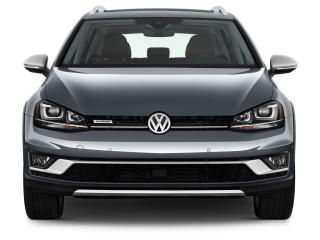

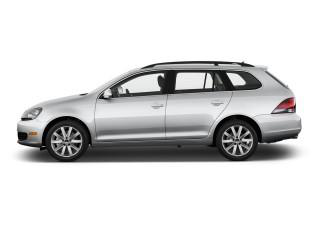

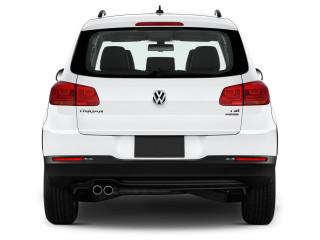

In [4]:
# DATA_PATH 경로의 모든 이미지 파일 불러오기
cars_images_path = list(glob(str(DATA_PATH + '*.jpg')))
for image_path in cars_images_path[:3]:
    display.display(Image.open(str(image_path)))

## Data Loader (TF API 사용)

In [5]:
@tf.function
def preprocessing_data(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_SHAPE[0],IMAGE_SHAPE[1]])
    image = image / 255.0
    return image

In [6]:
def dataloader(paths):
    dataset = tf.data.Dataset.from_tensor_slices(paths)
    dataset = dataset.shuffle(10 * BATCH_SIZE)
    dataset = dataset.map(preprocessing_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


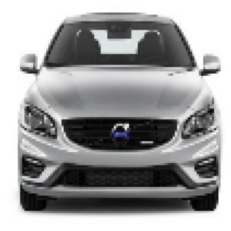

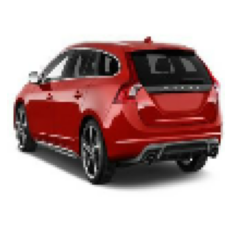

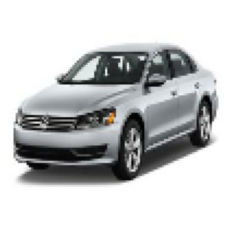

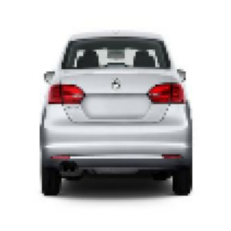

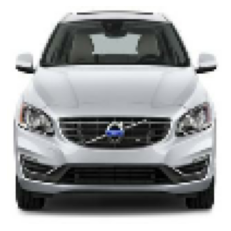

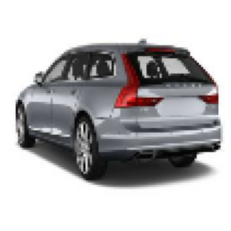

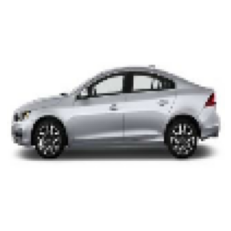

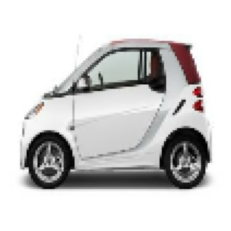

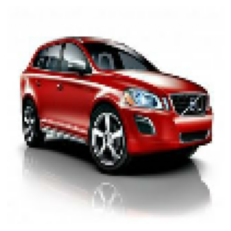

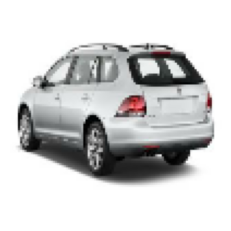

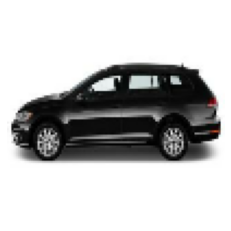

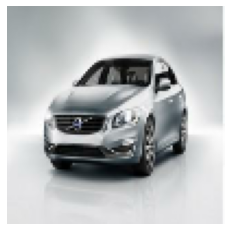

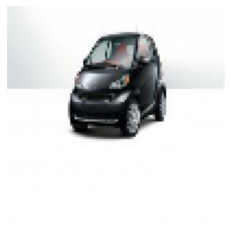

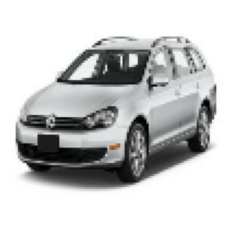

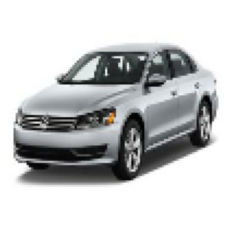

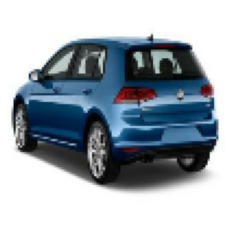

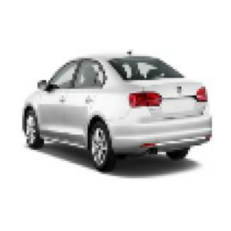

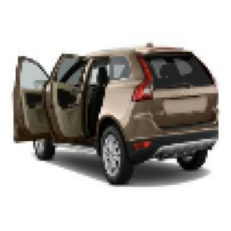

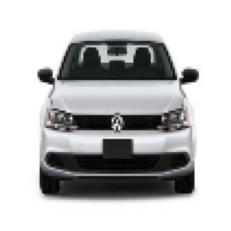

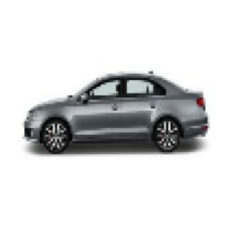

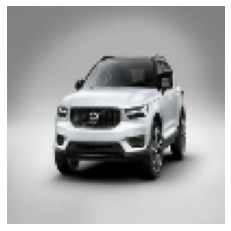

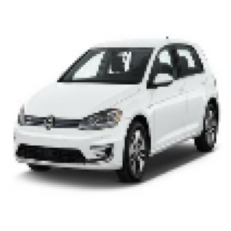

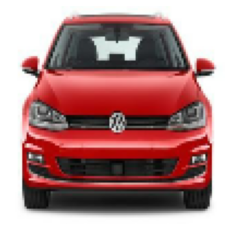

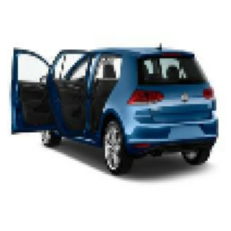

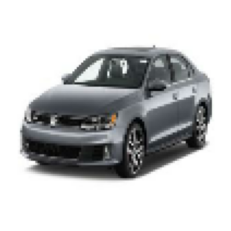

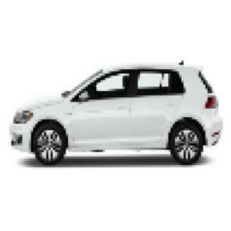

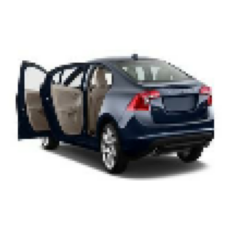

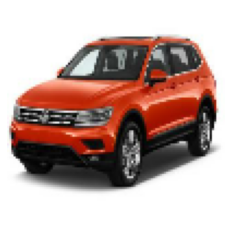

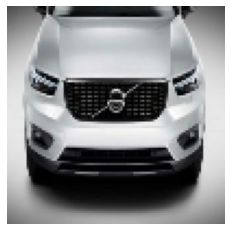

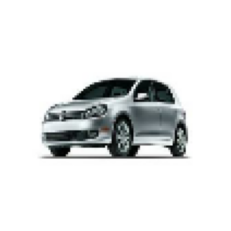

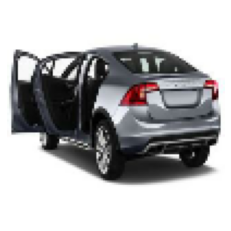

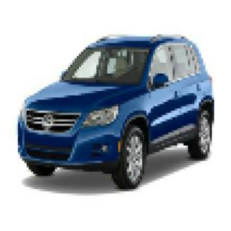

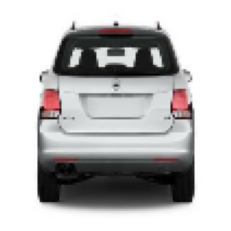

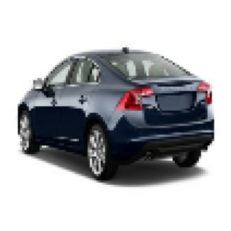

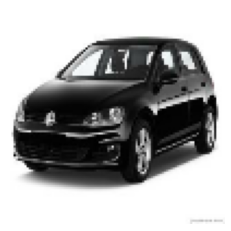

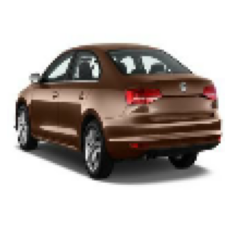

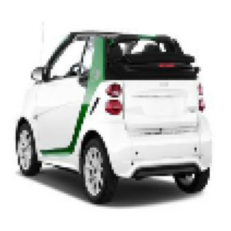

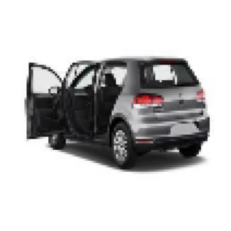

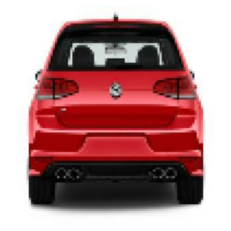

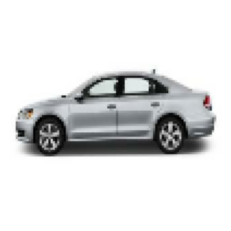

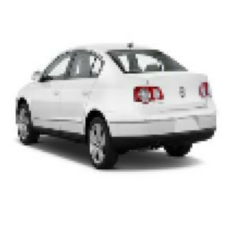

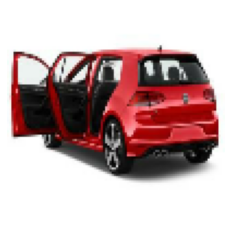

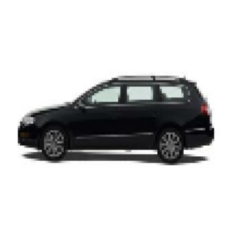

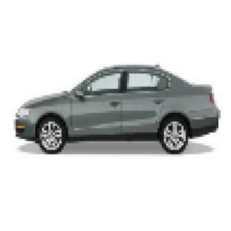

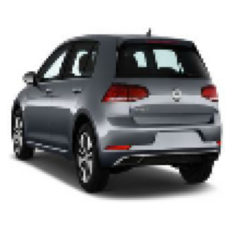

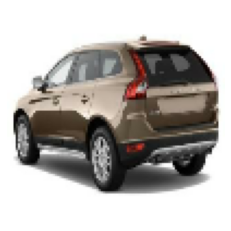

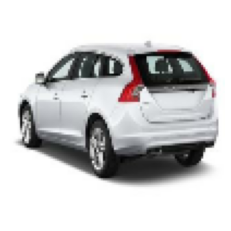

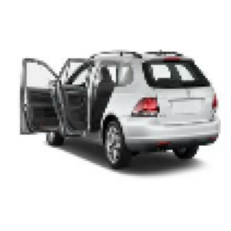

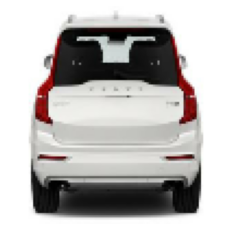

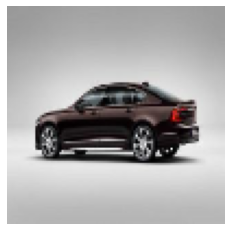

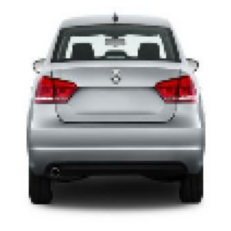

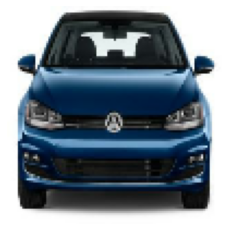

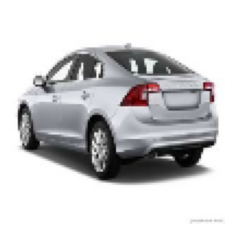

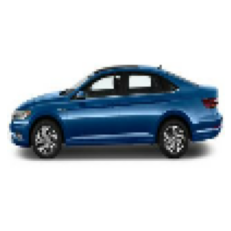

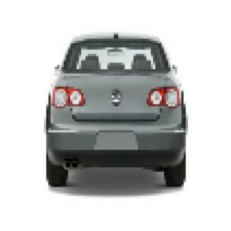

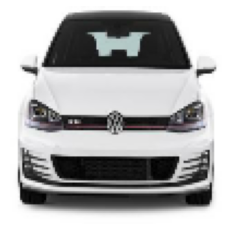

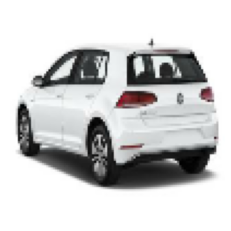

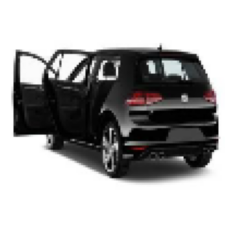

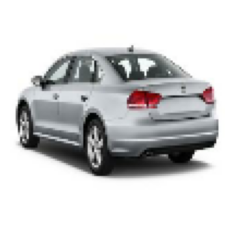

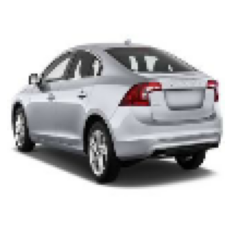

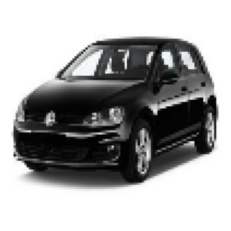

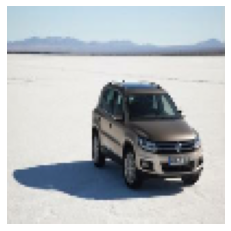

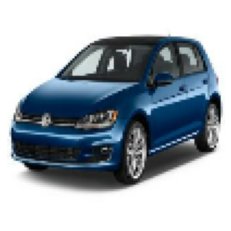

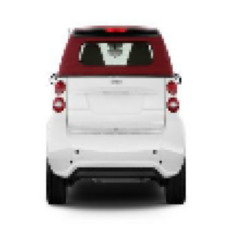

In [7]:
dataset = dataloader(cars_images_path)
for batch in dataset.take(1):
    for img in batch:
        img_np = img.numpy()
        plt.figure()
        plt.axis('off')
        plt.imshow((img_np-img_np.min())/(img_np.max()-img_np.min()))

## Modeling

![image](https://user-images.githubusercontent.com/44194558/138093085-65791758-fefa-4460-9813-5dfc45c5948c.png)

**WGAN에서 변경된 사항**

1. critic loss에 대해 gradient penalty를 포함시킴

2. critic weight clipping 사용 x

3. critic에서 배치 정규화 사용 x (배치 정규화는 동일한 배치의 샘플간에 상관 관계를 생성하기 때문에, 실험에 의해 확인 된 gradient penalty 효과에 영향을 줌)

### Generator

WGAN과 동일

In [8]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(25*25*128, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Reshape((25, 25, 128)))
    assert model.output_shape == (None, 25, 25, 128) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 25, 25, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 50, 50, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='sigmoid'))
    assert model.output_shape == (None, 100, 100, 3)
    model.summary()
    return model

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 80000)             8000000   
_________________________________________________________________
batch_normalization_3 (Batch (None, 80000)             320000    
_________________________________________________________________
re_lu_5 (ReLU)               (None, 80000)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 25, 25, 128)       0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 25, 25, 128)       409600    
_________________________________________________________________
batch_normalization_4 (Batch (None, 25, 25, 128)       512       
_________________________________________________________________
re_lu_6 (ReLU)               (None, 25, 25, 128)      

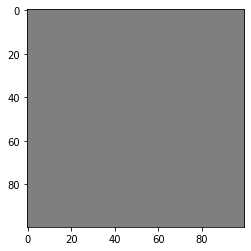

In [13]:
generator = make_generator_model()
noise = tf.random.normal([1, LATENT_DEPTH])
generated_image = generator(noise, training=True)

plt.imshow(generated_image[0, :, :, :], cmap='gray')

### Critic

정확한 gradient가 없으면 생성자가 더 나은 샘플을 생성하기 위한 가중치 조정 방법을 배울 수 없기 때문에 강력한 critic이 필요함.

sigmoid를 사용하지 않음

critic을 생성자보다 많이 훈련시킴 (논문에선 5회)

**WGAN에서 변경된 사항**

1. batch noramlization을 사용는 대신 LayerNormalization을 사용 (동일한 배치의 샘플 간에 상관 관계를 생성하기 때문)

2. weight clipping을 gradient clipping으로 대체

`Most prior GAN implementations use batch normalization in both the generator and the discriminator to help stabilize training, but batch normalization changes the form of the discriminator’s problem from mapping a single input to a single output to mapping from an entire batch of inputs to a batch of outputs. Our penalized training objective is no longer valid in this setting, since we penalize the norm of the critic’s gradient with respect
to each input independently, and not the entire batch. To resolve this, we simply omit batch normalization in the critic in our models, finding that they perform well without it. Our method works with normalization schemes which don’t introduce correlations between examples. In particular, we recommend layer normalization as a drop-in replacement for batch normalization.` 

In [11]:
def make_critic_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[100, 100, 3]))
    model.add(layers.ReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    model.summary()
    return model

In [12]:
critic = make_critic_model()
decision = critic(generated_image)
print (decision)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 50, 50, 64)        4864      
_________________________________________________________________
re_lu_3 (ReLU)               (None, 50, 50, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 128)       204928    
_________________________________________________________________
re_lu_4 (ReLU)               (None, 25, 25, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25, 25, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 80000)            

## Training Process

### Loss and Optimization

In [15]:
# WGAN과 동일
def critic_loss(r_logit, f_logit):
    real_loss = - tf.reduce_mean(r_logit)
    fake_loss = tf.reduce_mean(f_logit)
    return real_loss, fake_loss

def generator_loss(f_logit):
    fake_loss = - tf.reduce_mean(f_logit)
    return fake_loss

In [14]:
# 두 이미지 사이를 interpolate하고 inerpolated 이미지의 gradient penalty loss를 계산한 후, discriminator loss에 합산
def gradient_penalty(real_images, fake_images):
    # pixelwise interpolated image set 생성
    epsilon = tf.random.normal([real_images.shape[0], 1, 1, 1], 0.0, 1.0)
    x_hat = epsilon * real_images + (1 - epsilon) * fake_images
    with tf.GradientTape() as t:
        t.watch(x_hat)

        # interpolated image에 대한 critic output
        d_hat = critic(x_hat)

    # gradient 계산 (batch단위가 아닌, 독립적인 개별 data point에 대한 gradient 계산)
    gradients = t.gradient(d_hat, x_hat)
    
    # gradient의 norm 계산
    ddx = tf.sqrt(tf.reduce_sum(gradients ** 2, axis=[1, 2]))
    gp = tf.reduce_mean((ddx - 1.0) ** 2)

    return gp

gradient penalty loss

![image](https://user-images.githubusercontent.com/44194558/138098444-d2acd7bb-3b5c-460c-b183-29d6b1014a2b.png)


In [16]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate= LR)
critic_optimizer = tf.keras.optimizers.Adam(learning_rate= LR)

In [17]:
def summary(name_data_dict,
            step=None,
            types=['mean', 'std', 'max', 'min', 'sparsity', 'histogram', 'image'],
            historgram_buckets=None,
            name='summary'):
    """Summary.
    Examples
    --------
    >>> summary({'a': data_a, 'b': data_b})
    """
    def _summary(name, data):
        if data.shape == ():
            tf.summary.scalar(name, data, step=step)
        else:
            if 'mean' in types:
                tf.summary.scalar(name + '-mean', tf.math.reduce_mean(data), step=step)
            if 'std' in types:
                tf.summary.scalar(name + '-std', tf.math.reduce_std(data), step=step)
            if 'max' in types:
                tf.summary.scalar(name + '-max', tf.math.reduce_max(data), step=step)
            if 'min' in types:
                tf.summary.scalar(name + '-min', tf.math.reduce_min(data), step=step)
            if 'sparsity' in types:
                tf.summary.scalar(name + '-sparsity', tf.math.zero_fraction(data), step=step)
            if 'histogram' in types:
                tf.summary.histogram(name, data, step=step, buckets=historgram_buckets)
            if 'image' in types:
                tf.summary.image(name, data, step=step)

    with tf.name_scope(name):
        for name, data in name_data_dict.items():
            _summary(name, data)

In [18]:
train_summary_writer = tf.summary.create_file_writer(os.path.join(MODEL_SAVE_PATH, 'summaries', 'train'))
checkpoint_prefix = os.path.join(CHECKPOINT_DIR, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=critic_optimizer,
                                 generator=generator,
                                 discriminator=critic)

In [19]:
def generate_and_save_images(model, epoch, noise):
    
    plt.figure(figsize=(15,10))

    for i in range(4):
        images = model(noise, training=False)
        
        image = images[0, :, :, :]
        image = np.reshape(image, [100, 100, 3])
        
        plt.subplot(1, 4, i+1)
        plt.axis('off')
        plt.title("Randomly Generated Images")
        plt.imshow(np.uint8(image), cmap='gray')
    plt.tight_layout()  
    plt.savefig(os.path.join(MODEL_SAVE_PATH,'image_at_epoch_{:02d}.png'.format(epoch)))
    plt.show()

In [20]:
# WGAN 참고
@tf.function
def train_generator(noise):
    with tf.GradientTape() as tape:
        # create fake image
        generated_images = generator(noise, training=True)

        fake_logit = critic(generated_images, training=True)
        # calculate generator loss
        g_loss = generator_loss(fake_logit)

    gradients = tape.gradient(g_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients, generator.trainable_variables))  # 생성자의 가중치만 업데이트 (critic은 따로)
    return {'Generator_loss': g_loss}

In [21]:
# WGAN과 차이 비교
@tf.function
def train_Critic(noise, real_img):
    with tf.GradientTape() as t:
        fake_img = generator(noise, training=True)

        real_logit = critic(real_img, training=True)
        fake_logit = critic(fake_img, training=True)

        real_loss, fake_loss = critic_loss(real_logit, fake_logit)

        # interpolation을 사용하여 gradient penalty loss를 계산하고, d_loss에 합산
        gp = gradient_penalty(real_img, fake_img)        
        d_loss = (real_loss + fake_loss) + gp * GRADIENT_PENALTY_WEIGHT

    D_grad = t.gradient(d_loss, critic.trainable_variables)
    critic_optimizer.apply_gradients(zip(D_grad, critic.trainable_variables))
    
    return {'Critic_loss': d_loss}

WGAN_practice의 train_Critic

![image](https://user-images.githubusercontent.com/44194558/138098205-2fae6530-0182-4c6c-808b-5bfe5152d8b9.png)

In [36]:
import numpy as np
from matplotlib import pyplot as plt
import csv
import math
import pandas


def combine_images(generated_images, height=100, width=100):
    num = generated_images.shape[0]
    if width is None and height is None:
        width = int(math.sqrt(num))
        height = int(math.ceil(float(num)/width))
    elif width is not None and height is None:  # height not given
        height = int(math.ceil(float(num)/width))
    elif height is not None and width is None:  # width not given
        width = int(math.ceil(float(num)/height))

    shape = generated_images.shape[1:3]
    image = np.zeros((height*shape[0], width*shape[1]),
                     dtype=np.float32)
    for index, img in enumerate(generated_images):
        i = int(index/width)
        j = index % width
        image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1]] = \
            img[:, :, 0]
    return image

참고 : https://github.com/XifengGuo/CapsNet-Keras/blob/master/utils.py

In [37]:
def train(dataset, epochs):
    with train_summary_writer.as_default():
        with tf.summary.record_if(True):
            for epoch in range(epochs):
                start = time.time()
                for image_batch in dataset:
                    C_loss_dict = train_Critic(NOISE, image_batch)
                summary(C_loss_dict, step=generator_optimizer.iterations, name='critic_loss')
                
                if critic_optimizer.iterations.numpy() % N_CRITIC == 0:
                    G_loss_dict = train_generator(NOISE)
                    summary(G_loss_dict, step=generator_optimizer.iterations, name='generator_losses')
                    
                display.clear_output(wait=True)
                generate_and_save_images(generator,
                                         epoch + 1, NOISE)
                
                if (epoch + 1) % 3 == 0:
                    checkpoint.save(file_prefix = checkpoint_prefix)
                    x_fake = generator(NOISE, training=False)
                    save_img = combine_images(x_fake)
                        
                print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, NOISE)

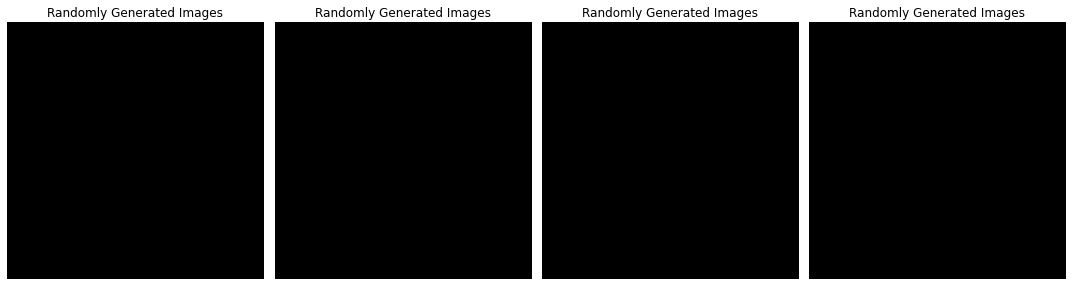

Time for epoch 318 is 11.638239622116089 sec


KeyboardInterrupt: ignored

In [38]:
train(dataset, EPOCHS)

In [ ]:
%tensorboard --logdir='/content/drive/My Drive/wgan_gp/results/summaries'

In [ ]:
anim_file = 'wgan_gp.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
    display.Image(filename=anim_file)